In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
%matplotlib inline

In [32]:
data1_parsed = np.load("data1.npz")

In [33]:
data1_parsed.files

['agri_military', 'labor', 'finance', 'health', 'gov', 'population_jobs']

In [84]:
labor = data1_parsed['labor']
agri_military = data1_parsed['agri_military']
health = data1_parsed['health']
finance = data1_parsed['finance']
gov = data1_parsed['gov']
population_jobs = data1_parsed['population_jobs']

In [37]:
set(labor['Series Code'])

{b'SL.TLF.TOTL.FE.ZS', b'SL.TLF.TOTL.IN'}

In [40]:
labor.dtype

dtype([('Series Name', 'S32'), ('Series Code', 'S32'), ('Country Name', 'S32'), ('Country Code', 'S32'), ('1991', '<f4'), ('1992', '<f4'), ('1993', '<f4'), ('1994', '<f4'), ('1995', '<f4'), ('1996', '<f4'), ('1997', '<f4'), ('1998', '<f4'), ('1999', '<f4'), ('2000', '<f4'), ('2001', '<f4'), ('2002', '<f4'), ('2003', '<f4'), ('2004', '<f4'), ('2005', '<f4'), ('2006', '<f4'), ('2007', '<f4'), ('2008', '<f4'), ('2009', '<f4'), ('2010', '<f4'), ('2011', '<f4'), ('2012', '<f4'), ('2013', '<f4'), ('2014', '<f4'), ('2015', '<f4')])

In [52]:
# Let's look at percentage of female workforce
female_wf = b'SL.TLF.TOTL.FE.ZS'
total_wf = b'SL.TLF.TOTL.IN'

In [74]:
# Parses year data in order given a row
def get_years(row):
    start_year = 1991
    end_year = 2015
    year_d = [[n, row[str(n)][0]] for n in range(start_year, end_year+1)]
    # remove any -1 values
    year_d = [d for d in year_d if d[1] != -1]
    return np.array(year_d)

In [56]:
us_wf = (labor['Series Code'] == total_wf) & (labor['Country Code'] == b"USA")
us_fe_wf = (labor['Series Code'] == female_wf) & (labor['Country Code'] == b"USA")

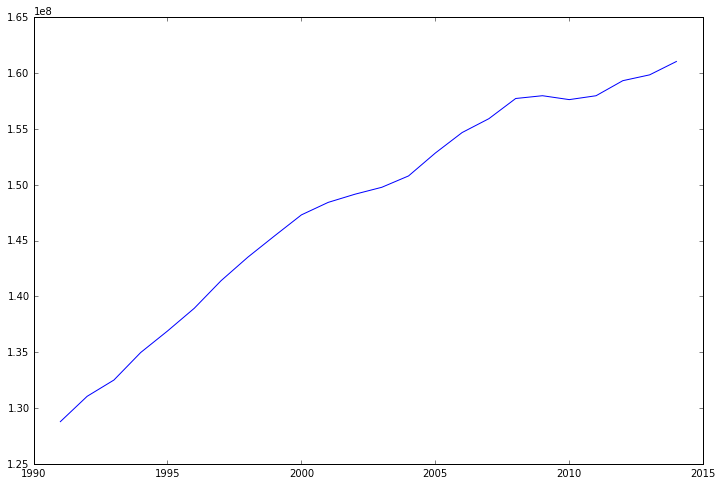

In [79]:
us_twf_years = get_years(labor[us_wf])
plt.plot(us_twf_years[:,0],us_twf_years[:,1])

In [95]:
dat = np.load("spreadsheets.npy")

In [99]:
years = [str(a) for a in range(1991,2016)]

In [109]:
maxyear = 2012
minyear = 1991
deltay = 3

# Series code we are predicting 
p_sc = b"SL.TLF.TOTL.FE.ZS"
cc = b"USA"

# Loop through all the years we know this series code < maxyear
sc_features = []
sc_out = []
for yearno in range(minyear + deltay, maxyear):

#     yearno = 1995
    yearno_s = yearno - 1991

    # Generate a table for this SC
    xrow = []
    # Loop through all other series codes excluding the current SC
    for sc in dat[(dat["Series Code"] != p_sc) & (dat['Country Code'] != cc)]:
        # Now we input the delta to the xrow
        xrow.append(sc[years[yearno_s - 1]] - sc[years[yearno_s - deltay - 1]])
    xrow = np.array(xrow)
    sc_features.append(xrow)
    
    p_sc_years = dat[(dat["Series Code"] == p_sc) & (dat['Country Code'] == cc)][0]
    sc_out.append(p_sc_years[years[yearno_s - 1]] - p_sc_years[years[yearno_s - deltay - 1]])
    
rows = np.array(rows)
sc_out = np.array(sc_out)

In [110]:
sc_out

array([  4.56894684e+01,   6.54880524e-01,   6.21089935e-01,
         6.50524139e-01,   3.28624725e-01,   2.57308960e-01,
         2.41256714e-01,   6.00013733e-02,   1.08612061e-01,
         8.23097229e-02,   2.90409088e-01,   2.14508057e-01,
         1.01280212e-01,  -8.02497864e-02,   2.18696594e-02,
         1.85352325e-01,   3.68785858e-01,   3.99261475e-01], dtype=float32)